# Shaft Speed Selection and Analysis Document

> Author: Elias Aoubala

> Date: 27/03/2025

In [2]:
import ross as rs
import numpy as np

## 1 - Background

This document contains the analysis and justification for the selection of the preliminary selection of the shaft speed of the turbopump.
A basic literature review is conducted to see what has been done, what is the current state-of-the-art, and what are the key drivers for the selection of the shaft speed of a turbopump.

## 2 - Literature Review

The shaft speed of turbopumps is an extremely influential parameter when it comes to the design to turbopump-driven cycles, as often it will drive the expected cycle performances of the system, coupled with being the key-contributor to the expected stresses the mechanical assembly will see.

Before discussing in detail the impacts of shaft speed selection have on the overall subsystem, for the sake of brevity, **discussion will be limited to assemblies which have a single shaft, just like the intended architecture of the Mermaid-man turbopump assembly, along with gas-generator based engine cycles.**

In-order to get a better idea of what has been done in terms of shaft speeds, a brief litterature review has been conducted to identify what has typically been used succesfully in the past on engines with significant heritage.

### 2.1 - Heritage Designs

A table of the engine name, propellants and turbopump shaft speeds have been presented below.

| Organsiation | Engine/Turbopump Name | Propellants | Shaft Speed (RPM) | Citation                                                                          |
| ------------ | --------------------- | ----------- | ----------------- | --------------------------------------------------------------------------------- |
| SpaceX       | Merlin 1-A            | LOX/RP-1    | 20,000            |                                                                                   |
| SpaceX       | Merlin 1-B            | LOX/RP-1    | 22,000            |                                                                                   |
| SpaceX       | Merlin 1-D            | LOX/RP-1    | 36,000            |                                                                                   |
| Perigee      | Blue 1-S              | LOX/LCH4    | 50,000            |                                                                                   |
| NASA         | Fastrac               | LOX/RP-1    | 20,000            | [NTRS](https://ntrs.nasa.gov/api/citations/19990009133/downloads/19990009133.pdf) |
| Ariane       | Vulcain 2             | LOX         | 35,680            | [Trollheden et al.](https://doi.org/10.2514/6.1999-2342)                          |
| Ariane       | Vulcain 2             | LH2         | 13,290            | [Mark and Windstrom](https://arc.aiaa.org/doi/abs/10.2514/6.1995-2404)            |
|              |                       |             |                   |                                                                                   |


## 3 - ROSS Model Instantiation

In order to evaluate the impact of the selection of shaft speed on system performance, the `ROSS` python package was used here.

This section covers the setup of a representative model of the `Mermaid Man` turbopump along with any key modelling assumptions.

### 3.1 - Baseline Rotor

The current baseline rotor consists of three bearings, a cartridge seal, a impeller and a turbine BLISK.

Influence of the cartridge seal on the static analysis and rotordynamics of the turbopump has been discounted at the current time due to limited information available.

Due to a lack of maturity in the turbin design, the turbine has been modelled as a simple cylindrical element with dimensions directly fed from the fluidic analysis previously conducted.

An image of the rotor can be found below:

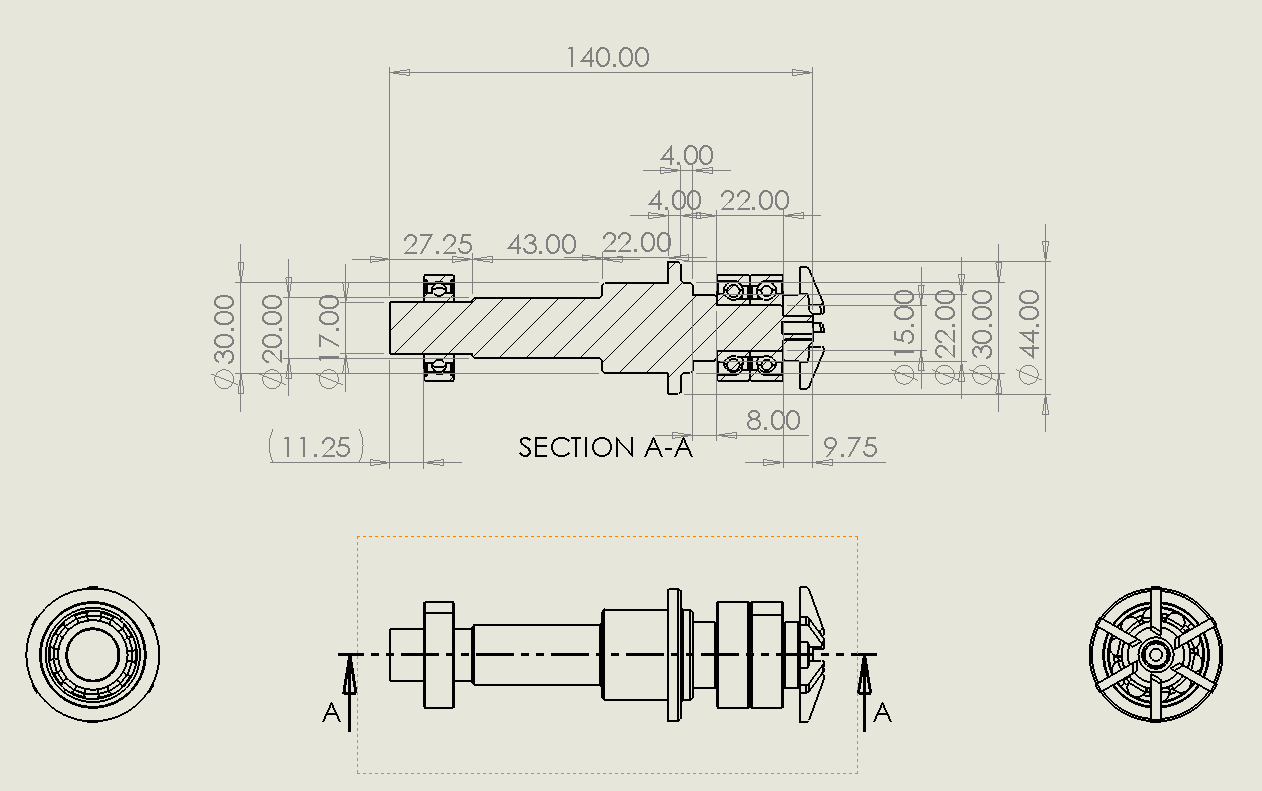

### 3.2 - Definition of Rotor Materials

For the shaft and blisk, the main material that will be used for the component manufacturing is `Stainless Steel SUS304` - primarily driven based on availability from suppliers that are within the budget of this project (JLCPCB).

Data for the Stainless Steel `SUS304` alloy has been derived from [matweb.com](https://www.matweb.com/search/datasheet.aspx?MatGUID=abc4415b0f8b490387e3c922237098da&ckck=1) and [AZO materials](https://www.azom.com/properties.aspx?ArticleID=965).

In [8]:
SUS304 = rs.Material(name="SUS304", rho = 8000, E = 193e9, G_s = 77e9)

print(SUS304)

SUS304
-----------------------------------
Density         (kg/m**3): 8000.0
Young`s modulus (N/m**2):  1.93e+11
Shear modulus   (N/m**2):  7.7e+10
Poisson coefficient     :  0.25324675


### 3.3 - Definition of Shaft Elements

Here, we define the architecture of our shaft including all the nodes and steps applied to it.

Where bearings have been placed, the stiffness has been assumed to apply "half-way" through the element, and thus the shaft node is split at this point.

In [9]:
shaft_elements = []
bearing_thickness = 11e-3 # m 

elements_array = {
    0: {
        "material": SUS304,
        "L": (11.25e-3 + bearing_thickness / 2),
        "odl": 17e-3,
        "idl": 0,
    },
    1: {
        "material": SUS304,
        "L": (27.25e-3 - 11.25e-3) - (bearing_thickness / 2),
        "odl": 17e-3,
        "idl": 0,
    },
    2: {"material": SUS304, "L": 43e-3, "odl": 20e-3, "idl": 0},
    3: {"material": SUS304, "L": 22e-3, "odl": 30e-3, "idl": 0},
    4: {"material": SUS304, "L": 4e-3, "odl": 44e-3, "idl": 0},
    5: {"material": SUS304, "L": 4e-3, "odl": 30e-3, "idl": 0},
    6: {"material": SUS304, "L": 8e-3, "odl": 22e-3, "idl": 0},
    7: {"material": SUS304, "L": (bearing_thickness / 2), "odl": 15e-3, "idl": 0},
    8: {"material": SUS304, "L": (bearing_thickness / 2), "odl": 15e-3, "idl": 0},
    9: {"material": SUS304, "L": (bearing_thickness / 2), "odl": 15e-3, "idl": 0},
    10: {"material": SUS304, "L": (bearing_thickness / 2), "odl": 15e-3, "idl": 0},
    11: {"material": SUS304, "L": 9.75 / 2 * 1e-3, "odl": 8e-3, "idl": 0},
    12: {"material": SUS304, "L": 9.75 / 2 * 1e-3, "odl": 8e-3, "idl": 0},
}

for element in elements_array:

    array = elements_array[element]

    shaft_elements.append(rs.ShaftElement(**array, n=element))

### 3.4 - Definition of Bearing Elements

For the bearing elements, the following bearing configuration has been selected:

- Rear Bearing (Blisk Side): [SKF 6003](https://www.skf.com/my/products/rolling-bearings/ball-bearings/deep-groove-ball-bearings/productid-6003%2FC3)
- Front Bearing Pair (Impeller Side): [SKF 7202](https://www.skf.com/group/products/rolling-bearings/ball-bearings/angular-contact-ball-bearings/single-row-angular-contact-ball-bearings/productid-7202%20BEP)

The `BallBearingElement` class is sued for the modelling of the bearing, and will automatically compute the stiffness for the bearing. No damping has been assumed in this model.

Key Parameters that need to be specified here are:

- `n`: Node where the bearing is placed
- `n_balls`: Number of balls within the bearing
- `d_balls`: Diameter of the balls within the bearing
- `fs`: Static Bearing Loading Force
- `alpha`: Contact Angle between bearing and inner/outer race

The static bearing loading Forces have been assumed based on a preliminary stress analysis estimating the radial forces on the bearings of approximately 800 N. Initially, an even distribution of these forces will be assumed. However a static analysis will be perfored to identify the reactions expected for the system with added weights at the impeller blisk.

For the static analysis, standard bearing class has been used.

`

#### 3.4.1 - Static Bearings

In [47]:
bearing_elements = []

kxx = 10e6
kyy = 10e6
cxx = 0
cyy = 0


elements_array = {
    "bearing_1": {
        "n": 1,
        "kxx": kxx,
        "kyy": kyy,
        "cxx": cxx,
        "cyy": cyy,
        "tag": "Rear Bearing",
    },
    "bearing_2": {
        "n": 8,
        "kxx": kxx,
        "kyy": kyy,
        "cxx": cxx,
        "cyy": cyy,
        "tag": "Front Bearing 1",
    },
    "bearing_3": {
        "n": 10,
        "kxx": kxx,
        "kyy": kyy,
        "cxx": cxx,
        "cyy": cyy,
        "tag": "Front Bearing 2",
    },
}

for element in elements_array:

    array = elements_array[element]

    bearing_elements.append(rs.BearingElement(**array))

#### 3.4.2 - Dynamic Bearings

In [27]:
bearing_elements = []

alpha = np.pi / 6

elements_array = {
    "bearing_1": {"n": 1, 
                  "n_balls": 10,
                  "d_balls": 8e-3,
                  "fs": 800/3,
                  "alpha": alpha
                  },
    "bearing_2": {"n": 8, 
                  "n_balls": 10,
                  "d_balls": 8e-3,
                  "fs": 800/3,
                  "alpha": alpha
                  },
    "bearing_3": {"n": 10, 
                  "n_balls": 10,
                  "d_balls": 8e-3,
                  "fs": 800/3,
                  "alpha": alpha
                  },
}

for element in elements_array:

    array = elements_array[element]

    bearing_elements.append(rs.BallBearingElement(**array))


### 3.5 - Definition of Disk Elements (Impeller and Blisk)

In this section we simply specify the two disk elements relevent for this analysis, which is the turbine disk and the pump impeller.

The turbine disk dimensions have been directly derived from the fluidic analysis conducted previously.

In [41]:
rotor_elements = []

turbine = rs.DiskElement.from_geometry(
    n=0, 
    i_d=17e-3, 
    o_d=0.155, 
    width=17e-3, 
    material=SUS304,
    tag="Turbine Blisk"
)

impeller = rs.DiskElement.from_geometry(
    n=12, i_d=15e-3, o_d=40e-3, width=3e-3, material=SUS304, tag="Impeller"
)

rotor_elements.append(turbine)
rotor_elements.append(impeller)

### 3.6 - Final Rotor Assembly

In [42]:
# Moment approach
mermaid_rotor = rs.Rotor(
    shaft_elements=shaft_elements,
    bearing_elements=bearing_elements,
    disk_elements=rotor_elements,
)

mermaid_rotor.plot_rotor()

### 3.7 - OPTIONAL: Static Analysis Augmentation

This section contains the augmentation to be performed for the static analysis, which namely revolves around the addition of the radial forces expected by the impeller and turbine and the specification of generic bearings to allow for the static analysis to be performed.

## 3 - Shaft Static Analysis

One of the first analysis performed on the turbopump was the static analysis on the shaft to identify how the stress distribution will be like on the shaft as it currently stands.

The `run_static` subroutine from ROSS has been used for this analysis

In [43]:
static = mermaid_rotor.run_static()

c:\Users\elias\Desktop\MermaidManBarnacleBoy\.venv\Lib\site-packages\ross\rotor_assembly.py:3300: LinAlgWarning:

Ill-conditioned matrix (rcond=2.05775e-17): result may not be accurate.



We can thus print our bearing and rotor Forces as the following:

In [44]:
print("Disk forces - nodes")
print(mermaid_rotor.disk_forces_nodal)
print("")
print("Disk forces - tags")
print(mermaid_rotor.disk_forces_tag)

print("")
print("Bearing forces - nodes")
print(mermaid_rotor.bearing_forces_nodal)
print("")
print("Bearing forces - tags")
print(mermaid_rotor.bearing_forces_tag)

Disk forces - nodes
{'node_0': 24.86281827712522, 'node_12': 0.2541662339487835}

Disk forces - tags
{'Turbine Blisk': 24.86281827712522, 'Impeller': 0.2541662339487835}

Bearing forces - nodes
{'node_1': np.float64(31.674603204105317), 'node_8': np.float64(-9.792708965581648), 'node_10': np.float64(7.281124040745645)}

Bearing forces - tags
{'Bearing 0': np.float64(31.674603204105317), 'Bearing 1': np.float64(-9.792708965581648), 'Bearing 2': np.float64(7.281124040745645)}


## 4 - Critical Speed Analysis

As a wide range of speeds have been demonstrated thus far, a low fidelity rotordynamic analysis is intended to be performed to drive the main selection of the shaft speed.
This analysis will be based on the first draft of the turbo-pump created in the winter, and will be updated accordingly.

An image of the current shaft and attached elements has been presented below:

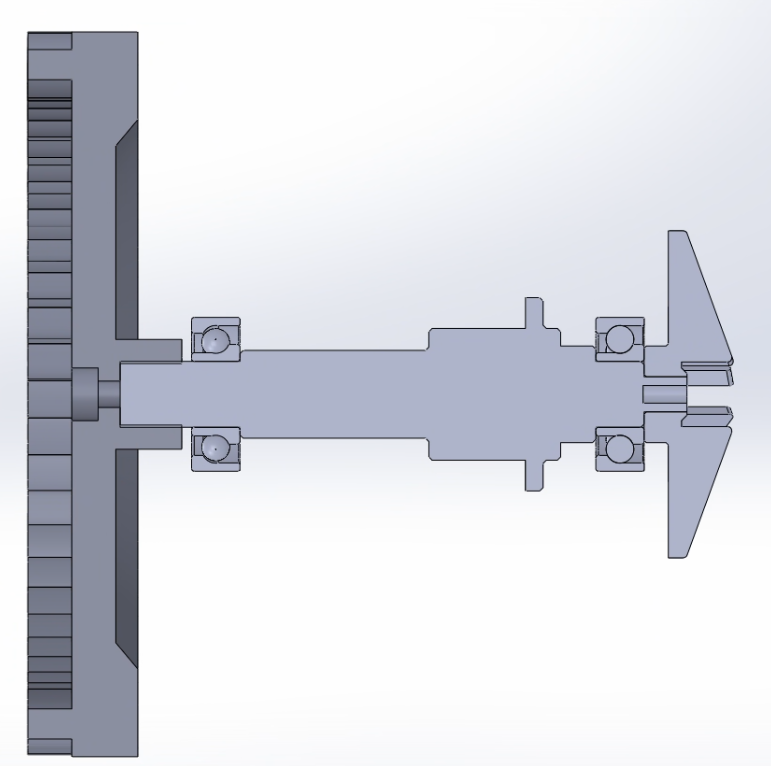

### 3.1 - Definition of Shaft Elements

Here, we define the architecture of our shaft including all the nodes and steps applied to it.

A simple "steel" shaft material, as default define by `ROSS` has been used for the present analysis. This will be updated as we apporach a more refined model.

Where bearings have been placed, the stiffness has been assumed to apply "half-way" through the element, and thus the shaft node is split at this point.

In [4]:
shaft_elements = []
bearing_thickness = 11e-3 # m 
steel = rs.steel

elements_array = {
    0: {
        "material": steel,
        "L": (27.25e-3 - bearing_thickness / 2),
        "odl": 15e-3,
        "idl": 0,
    },
    1: {"material": steel, "L": (bearing_thickness / 2), "odl": 15e-3, "idl": 0},
    2: {"material": steel, "L": 41.5e-3, "odl": 20e-3, "idl": 0},
    3: {"material": steel, "L": 22e-3, "odl": 30e-3, "idl": 0},
    4: {"material": steel, "L": 4e-3, "odl": 44e-3, "idl": 0},
    5: {"material": steel, "L": 4e-3, "odl": 30e-3, "idl": 0},
    6: {"material": steel, "L": 8e-3, "odl": 22e-3, "idl": 0},
    7: {"material": steel, "L": (bearing_thickness / 2), "odl": 15e-3, "idl": 0},
    8: {"material": steel, "L": (bearing_thickness / 2), "odl": 15e-3, "idl": 0},
    9: {"material": steel, "L": 9.25 / 2 * 1e-3, "odl": 8e-3, "idl": 0},
    10: {"material": steel, "L": 9.25 / 2 * 1e-3, "odl": 8e-3, "idl": 0},
}

for element in elements_array:

    array = elements_array[element]

    shaft_elements.append(rs.ShaftElement(**array, n=element))

### 3.2 - Definition of Bearing Elements

For the bearing elements, standard skf elements have been used, with the bearing stifnessess derived by [INSERT METHOD HERE].

In the design, only two shaft elements are present, so we can pretty simply specify these and associated stifness.

In [5]:
bearing_elements = []

kxx = 10e6
kyy = 10e6
cxx = 0
cyy = 0


elements_array = {
    "bearing_1": {"n": 1, "kxx": kxx, "kyy": kyy, "cxx": cxx, "cyy": cyy},
    "bearing_2": {"n": 8, "kxx": kxx, "kyy": kyy, "cxx": cxx, "cyy": cyy},
}

for element in elements_array:

    array = elements_array[element]

    bearing_elements.append(rs.BearingElement(**array))

### 3.3 - Disk Element Generation

In this section we simply specify the two disk elements relevent for this analysis, which is the turbine disk and the pump impeller.

At this stage, lowfidelity modelling has been used.

In [2]:
rotor_elements = []

steel = rs.Material(name="Stainless 316", rho = 8000, E = 200e9)

rotor_elements.append(rs.DiskElement.from_geometry(n=0 , i_d = 15e-3, o_d= 165e-3, width= 15e-3, material=steel))
rotor_elements.append(rs.DiskElement.from_geometry(n=11 , i_d = 8e-3, o_d= 40e-3, width= 3e-3, material=steel))

NameError: name 'rs' is not defined

### 3.4 - Final Rotor Assembly

In [1]:
# Moment approach
mermaid_rotor = rs.Rotor(
    shaft_elements=shaft_elements,
    bearing_elements=bearing_elements,
    disk_elements=rotor_elements,
)

mermaid_rotor.plot_rotor()

mermaid_rotor.Ip

NameError: name 'rs' is not defined

In [43]:
range = np.linspace(1,100e3, 50)*2*np.pi/60

campbell = mermaid_rotor.run_campbell(speed_range=range)


campbell.plot()

Based on this analysis, we can immediately see that first two modes are sub 20k rpm, however the next mode after that is extremely high at 75k rpm.

Based on this extremely low fidelity model and likely inaccurate model, a shaft speed of 30 k rpm has been selected.

This analysis will be updated once an up-to-date turbopump has been created.